#Job Shop Scheduling

Job shop scheduling is one of the classic problems in Operations Research.

A job shop refers to a collection of machines that process jobs. The jobs may be simple or complex, such as the production of a custom part, a print job at printing house, a patient treated in a hospital, or a meal produced in a fast food restaurant. The term "machines" can refer any device, person, or resource involved in the processing the jobs. In what follows in this notebook, a job comprises a series of tasks that requiring use of particular machines for known duration, and which must be completed in specified order.

The job shop scheduling problem is to schedule a set of jobs on the available machines to optimize a metric of productivity. A typical metric is the makespan which refers to the time needed to process all jobs.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import copy
import random
import math

## Some Theory

**Genetic Algorithms** (GA) are based on **evolutionary approach** to AI, in which methods of evolution of population is used to obtain an optimal solution for a given problem. They were proposed in 1975 by [John Henry Holland](https://en.wikipedia.org/wiki/John_Henry_Holland).

Genetic Algorithms are based on the following ideas:
* Valid solutions to the problem can be represented as **genes**
* **Crossover** allows us to combine two solutions together to obtain new valid solution
* **Selection** is used to select more optimal solutions using some **fitness function**
* **Mutations** are introduced to destabilize optimization and get us out of the local minimum

If you want to implement a Genetic Algorithm, you need the following:

 * To find a method of coding our problem solutions using **genes** $g\in\Gamma$
 * On the set of genes $\Gamma$ we need to define **fitness function** $\mathrm{fit}: \Gamma\to\mathbb{R}$. Smaller function values would correspond to better solutions.
 * To define **crossover** mechanism to combine two genes together to get a new valid solution $\mathrm{crossover}: \Gamma^2\to\Gamma$.
 * To define **mutation** mechanism $\mathrm{mutate}: \Gamma\to\Gamma$.
In many cases, crossover and mutation are quite simple algorithms to manipulate genes as numeric sequences or bit vectors.

Specific implementation of a genetic algorithm can vary from case to case, but overall structure is the following:

1. Select initial population $G\subset\Gamma$
2. Randomly select one of the operations that will be performed at this step: crossover or mutation
3. **Crossover**:
  * Randomly select two genes $g_1, g_2 \in G$
  * Compute crossover $g=\mathrm{crossover}(g_1,g_2)$
  * If $\mathrm{fit}(g)<\mathrm{fit}(g_1)$ or $\mathrm{fit}(g)<\mathrm{fit}(g_2)$ - replace corresponding gene in the population by $g$.
4. **Mutation** - select random gene $g\in G$ and replace it by $\mathrm{mutate}(g)$
5. Repeat from step 2, until we get sufficiently small value of $\mathrm{fit}$, or until the limit on the number of steps is reached.

Let's now define `fit` function that calculates the "cost" of the solution.


In [ ]:
def makespan(chromosomes, population_size, num_jobs, process_time, num_machines, machine_sequence):

    chrom_fitness, chrom_fit=[],[]
    for pop_size in range(population_size):
        j_keys=[j for j in range(num_jobs)]
        key_count={key:0 for key in j_keys}
        j_count = {key:0 for key in j_keys}
        m_keys = [j+1 for j in range(num_machines)]
        m_count = {key:0 for key in m_keys}
        for i in chromosomes[pop_size]:
            get_time=int(process_time[i][key_count[i]])
            gen_mach = int(machine_sequence[i][key_count[i]])
            j_count[i]=j_count[i]+get_time
            print(gen_mach,m_count)
            m_count[gen_mach]=m_count[gen_mach]+get_time
            if m_count[gen_mach] < j_count[i]:
                    m_count[gen_mach] = j_count[i]
            elif m_count[gen_mach] > j_count[i]:
                    j_count[i] = m_count[gen_mach]

            key_count[i] = key_count[i] + 1

        makespan = max(j_count.values())
        chrom_fitness.append(1/makespan)
        chrom_fit.append(makespan)


    return chrom_fit, chrom_fitness


In [ ]:
def cost_func(chromosomes, population_size, num_job, process_time, num_machine, machine_sequence,):
    chrom_fit, chrom_fitness=makespan(chromosomes, population_size, num_job, process_time, num_machine, machine_sequence)
    return chrom_fitness, chrom_fit


In [ ]:
def rank(cost, chromosomes, population_size, num_job, process_time, num_machine, machine_sequence, population_list):
    costs, chrom_fit = cost_func(chromosomes, population_size, num_job, process_time, num_machine, machine_sequence)
    ranked = sorted(list(zip(chromosomes, costs, chrom_fit, population_list)), key=lambda c: c[2])
    ranked_chrom, ranked_costs, ranked_chrom_fit, ranked_population_list = list(zip(*ranked))
    ranked_chrom = list(ranked_chrom)
    ranked_chrom_fit = list(ranked_chrom_fit)
    return ranked_chrom, ranked_costs, ranked_chrom_fit


**Selection** is an operation that chooses individuals from the current population to parent the next generation. The selection process is typically based on the fitness of the individuals, with those having lower (for ma-higher) fitness values being more likely to be selected.

In [ ]:
def natural_selection(ranked_parents, n):
    return ranked_parents[:n]


**Roulette selection**, also known as roulette wheel selection, is a method used in Genetic Algorithms to select individuals for reproduction based on their fitness. Here's how it works:

*  Fitness Proportionate: Each individual's probability of being selected is proportional to its fitness. Higher fitness individuals have a larger slice of the "roulette wheel."

*  Roulette Wheel: Imagine a roulette wheel where each individual has a segment size corresponding to its fitness. The wheel is spun, and the individual where the pointer lands is selected.

*  Selection Process: This process is repeated until the desired number of individuals is selected for reproduction.

Roulette selection ensures that fitter individuals have a higher chance of being selected, but it also gives less fit individuals a chance, maintaining genetic diversity.

In [ ]:
def roulette_selection(parents):

  pairs = []
  i = 0
  for i in range(0, len(parents), 2):
    weights=[];
    for i in range(len(parents)):
        weights.append((len(parents)-i)*random.random())
    if (weights[0]>=weights[1]):
        maxInd1=0;
        maxInd2=1;
    else:
        maxInd1=1;
        maxInd2=0;

    for i in range(2,len(parents)):
        if weights[i]>weights[maxInd1]:
            maxInd2=maxInd1
            maxInd1=i
        elif weights[i]>weights[maxInd2]:
            maxInd2=1
    pairs.append([parents[maxInd1], parents[maxInd2]])

  return pairs


In a Job Shop Scheduling Problem (JSSP), the initial population in a Genetic Algorithm (GA) consists of a set of potential solutions (schedules) that are generated to start the evolutionary process.
 Each individual in the population can be represented as a permutation of operations. This encoding helps in maintaining feasible schedules during crossover and mutation operations.

In [ ]:
def generate_initial_population(num_job,num_mach, population_size):
    population=[]
    init_list=[]
    for i_job in range(0,num_job):
        for j_mach in range(0,num_mach):
            init_list.append(i_job)
    for i in range(0,population_size):
      permuted_lst = init_list[:]  # Create a copy of the list
      random.shuffle(permuted_lst)  # Shuffle the copy in place
      population.append(permuted_lst)

    return population



In [ ]:
pop=generate_initial_population(3,3,5)
print(pop)

[[0, 0, 1, 1, 2, 1, 2, 0, 2], [2, 2, 0, 2, 1, 1, 1, 0, 0], [0, 2, 1, 2, 1, 0, 1, 0, 2], [2, 0, 1, 0, 2, 2, 1, 0, 1], [2, 0, 0, 1, 0, 1, 1, 2, 2]]


In the context of the Job Shop Scheduling Problem (JSSP) using Genetic Algorithms (GAs), mutation is an operator used to introduce diversity into the population by making small random changes to individual schedules.

*Swap Mutation:* Two operations within a schedule are randomly selected and swapped. This can help explore different sequences of operations.

In [ ]:
def mutation(population_list,mutation_rate):
 # TO DO

  return population_mutation


In [ ]:
print(pop)
pop_mutat=mutation(pop,0.9)

print(pop_mutat)

[[0, 0, 1, 1, 2, 1, 2, 0, 2], [2, 2, 0, 2, 1, 1, 1, 0, 0], [0, 2, 1, 2, 1, 0, 1, 0, 2], [2, 0, 1, 0, 2, 2, 1, 0, 1], [2, 0, 0, 1, 0, 1, 1, 2, 2]]
[[0, 0, 2, 1, 1, 1, 2, 0, 2], [2, 2, 0, 2, 1, 1, 1, 0, 0], [0, 0, 1, 2, 1, 2, 1, 0, 2], [2, 0, 1, 0, 2, 2, 1, 0, 1], [2, 0, 0, 1, 0, 1, 1, 2, 2]]


Crossover (or recombination) is an operator that combines parts of two parent solutions to produce one or more offspring solutions. The goal of crossover is to combine the strengths of the parents to create better-performing offspring.



In [ ]:
def crossover(pairs, num_job):
    # TO DO
    return new_population

Elitism is a strategy used to ensure that the best individuals (solutions) from the current generation are preserved and carried over to the next generation without undergoing mutation or crossover.

In [ ]:
def elitis(ranked_parenst, ranked_children, elitis_rate, population_size):
    old_ind_size=int(np.round(population_size*elitis_rate))
    return ranked_parenst[:old_ind_size]+ranked_children[:(population_size-old_ind_size)]


This flowchart outlines the typical steps in a GA:

1.   Initialization: Generate the initial population.
2.   Evaluation: Assess the fitness of each individual.
3.   Selection: Select individuals for reproduction based on fitness.
4.   Crossover: Combine pairs of parents to create offspring.
5.   Mutation: Introduce random changes to offspring.
6.   Replacement: Form the new population.
7.   Termination: Check if the stopping condition is met (e.g., number of generations, convergence).

In [ ]:
def job_schedule(process_time,machine_sequence,cost_func, population_size = 10, elitis_rate=0.1, mutation_rate=0.3, inverse_mutation_rate=0.2, num_iteration = 20):
    makespan_record=[]


    num_job,num_machine=process_time.shape

    avg_list=[]
    Tbest=math.inf
    same=0

    population_list=generate_initial_population(num_job, num_machine,population_size)
    chromosomes=population_list

    for iteration in range(num_iteration):
        Tbest_now = math.inf

        parents, costs, chrom_fit=rank(cost_func,chromosomes, population_size, num_job, process_time, num_machine, machine_sequence, population_list)

        pairs=roulette_selection(parents)

        offspring_list= crossover(pairs, num_job)

        offspring_list=mutation(offspring_list,mutation_rate)



        ranked_children,costs_children,chrom_fit_children=rank(cost_func,offspring_list,population_size,num_job,process_time,num_machine,machine_sequence,population_list)

        chromosomes=elitis(parents,ranked_children,elitis_rate,population_size)


        for pop_size in range(population_size):
            if chrom_fit[pop_size] < Tbest_now:
                Tbest_now = chrom_fit[pop_size]
                sequence_now = copy.deepcopy(chromosomes[pop_size])
        if Tbest_now < Tbest:
            Tbest = Tbest_now
            sequence_best = copy.deepcopy(sequence_now)
        if Tbest_now==Tbest:
            same+=1
        if same>15:
            break
        makespan_record.append(Tbest)

    print("optimal sequence", sequence_best)
    print("optimal value:%f"%Tbest)
    print("\n")

    plt.plot([i for i in range(len(makespan_record))],makespan_record,'b')
    plt.ylabel('makespan', fontsize=15)
    plt.xlabel('generation', fontsize=15)
    plt.show()

    return Tbest,sequence_best


In [ ]:
def schedule_form(schedule,process_time):

    num_jobs,num_machines=process_time.shape
    j_keys = [j for j in range(num_jobs)]
    key_count = {key: 0 for key in j_keys}
    j_count = {key: 0 for key in j_keys}
    m_keys = [j + 1 for j in range(num_machines)]
    m_count = {key: 0 for key in m_keys}
    schedule_form = []

    for i in schedule:
        item={}
        item['job']=i
        get_time = int(process_time[i][key_count[i]])
        gen_mach = int(machine_sequence[i][key_count[i]])
        item['machine'] = gen_mach
        item['start'] = max(m_count[gen_mach], j_count[i])
        j_count[i] = j_count[i] + get_time

        m_count[gen_mach] = m_count[gen_mach] + get_time
        if m_count[gen_mach] < j_count[i]:
            m_count[gen_mach] = j_count[i]
        elif m_count[gen_mach] > j_count[i]:
            j_count[i] = m_count[gen_mach]
        item['end'] = j_count[i]
        key_count[i] = key_count[i] + 1

        schedule_form.append(item)
    return schedule_form


In [ ]:
def plot_gantt_chart(schedule):

    fig, ax = plt.subplots()

    # Assign colors to jobs
    job_colors = {}
    for job in schedule:
        if job['job'] not in job_colors:
            job_colors[job['job']] = plt.cm.tab20(job['job'] % 20)

    # Add tasks to the chart
    for task in schedule:
        job = task['job']
        machine = task['machine']
        start = task['start']
        end = task['end']
        ax.add_patch(mpatches.Rectangle((start, machine - 0.4), end - start, 0.8, color=job_colors[job]))
        ax.text((start + end) / 2, machine, f'Job {job}', ha='center', va='center', color='white')

    # Set labels and title
    machines = sorted(set(task['machine'] for task in schedule))
    ax.set_yticks([i for i in range(1, max(task['machine'] for task in schedule) + 1)])
    ax.set_yticklabels([f'Machine {i}' for i in range(1, max(task['machine'] for task in schedule) + 1)])
    ax.set_ylim(min(machines) - 0.5, max(machines) + 0.5)
    max_end_time = max(task['end'] for task in schedule)
    ax.set_xticks(range(0, max_end_time + 1))
    ax.set_xlabel('Time')
    ax.set_ylabel('Machine')
    ax.set_title('Gantt Chart for Job Shop Scheduling')

    plt.show()

Streaming output truncated to the last 5000 lines.
1 {1: 13, 2: 22, 3: 18, 4: 26, 5: 28, 6: 17}
6 {1: 26, 2: 22, 3: 18, 4: 26, 5: 28, 6: 17}
5 {1: 26, 2: 22, 3: 18, 4: 26, 5: 28, 6: 29}
6 {1: 26, 2: 22, 3: 18, 4: 26, 5: 37, 6: 29}
3 {1: 26, 2: 22, 3: 18, 4: 26, 5: 37, 6: 39}
1 {1: 26, 2: 22, 3: 23, 4: 26, 5: 37, 6: 39}
4 {1: 49, 2: 22, 3: 23, 4: 26, 5: 37, 6: 39}
2 {1: 49, 2: 22, 3: 23, 4: 29, 5: 37, 6: 39}
6 {1: 49, 2: 27, 3: 23, 4: 29, 5: 37, 6: 39}
5 {1: 49, 2: 27, 3: 23, 4: 29, 5: 37, 6: 49}
5 {1: 49, 2: 27, 3: 23, 4: 29, 5: 45, 6: 49}
1 {1: 49, 2: 27, 3: 23, 4: 29, 5: 52, 6: 49}
4 {1: 53, 2: 27, 3: 23, 4: 29, 5: 52, 6: 49}
5 {1: 53, 2: 27, 3: 23, 4: 54, 5: 52, 6: 49}
4 {1: 53, 2: 27, 3: 23, 4: 54, 5: 58, 6: 49}
6 {1: 53, 2: 27, 3: 23, 4: 58, 5: 58, 6: 49}
3 {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0}
2 {1: 0, 2: 0, 3: 5, 4: 0, 5: 0, 6: 0}
1 {1: 0, 2: 5, 3: 5, 4: 0, 5: 0, 6: 0}
2 {1: 10, 2: 5, 3: 5, 4: 0, 5: 0, 6: 0}
3 {1: 10, 2: 13, 3: 5, 4: 0, 5: 0, 6: 0}
3 {1: 10, 2: 13, 3: 8, 4: 0, 5:

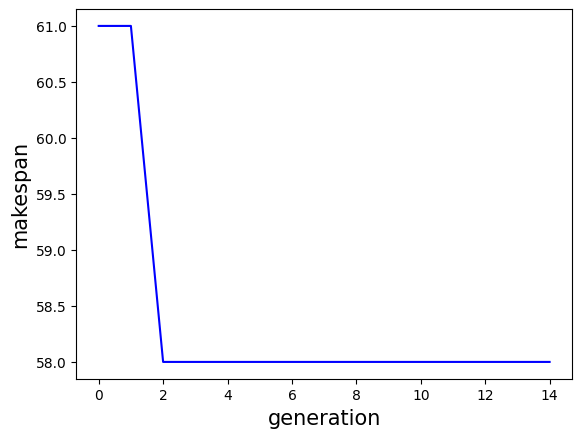

[{'job': 2, 'machine': 3, 'start': 0, 'end': 5}, {'job': 3, 'machine': 2, 'start': 0, 'end': 5}, {'job': 3, 'machine': 1, 'start': 5, 'end': 10}, {'job': 1, 'machine': 2, 'start': 5, 'end': 13}, {'job': 4, 'machine': 3, 'start': 5, 'end': 8}, {'job': 0, 'machine': 3, 'start': 8, 'end': 9}, {'job': 2, 'machine': 4, 'start': 5, 'end': 9}, {'job': 1, 'machine': 3, 'start': 13, 'end': 18}, {'job': 2, 'machine': 6, 'start': 9, 'end': 17}, {'job': 0, 'machine': 1, 'start': 10, 'end': 13}, {'job': 0, 'machine': 2, 'start': 13, 'end': 19}, {'job': 1, 'machine': 5, 'start': 18, 'end': 28}, {'job': 4, 'machine': 2, 'start': 19, 'end': 22}, {'job': 2, 'machine': 1, 'start': 17, 'end': 26}, {'job': 0, 'machine': 4, 'start': 19, 'end': 26}, {'job': 0, 'machine': 6, 'start': 26, 'end': 29}, {'job': 4, 'machine': 5, 'start': 28, 'end': 37}, {'job': 1, 'machine': 6, 'start': 29, 'end': 39}, {'job': 3, 'machine': 3, 'start': 18, 'end': 23}, {'job': 1, 'machine': 1, 'start': 39, 'end': 49}, {'job': 3, '

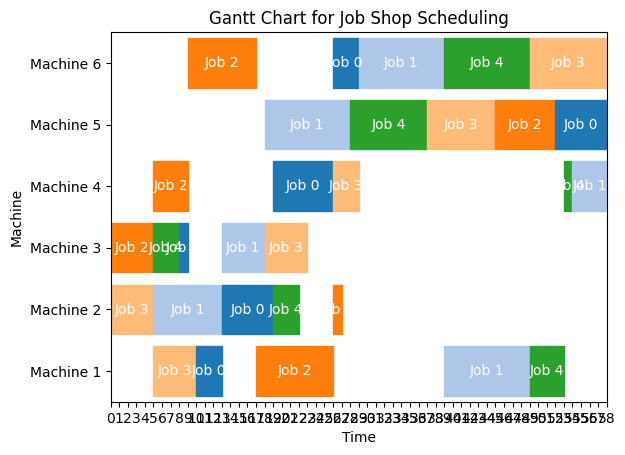

In [ ]:
# machine_sequence = np.array([[3,1,2,4,6,5],[2,3,5,6,1,4], [3,4,6,1,2,5],[2,1,3,4,5,6],[3,2,5,6,1,4],[2,4,6,1,5,3]])
# process_time = np.array([[1,3,6,7,3,6],[8,5,10,10,10,4],[5,4,8,9,1,7],[5,5,5,3,8,9],[3,3,9,10,4,1]])


machine_sequence = np.array([[3,1,2,4,6,5],[2,3,5,6,1,4], [3,4,6,1,2,5],[2,1,3,4,5,6],[3,2,5,6,1,4],[2,4,6,1,5,3]])
process_time = np.array([[1,3,6,7,3,6],[8,5,10,10,10,4],[5,4,8,9,1,7],[5,5,5,3,8,9],[3,3,9,10,4,1]])


time,schedule = job_schedule(process_time,machine_sequence,cost_func)
schedule=schedule_form(schedule,process_time)
print(schedule)
plot_gantt_chart(schedule)